In [20]:
from scipy import fftpack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## utils

In [21]:
def cyc_sec(time_vec): #calculate  cycles per second
    n = time_vec.iloc[0]
    avgs = []
    while n < time_vec.iloc[-1]:
        recs = len(time_vec[(time_vec >n) & (time_vec<n+ 1e+9)])
        avgs.append(recs)
        n= n+1e+9
    plt.plot(avgs)
    return round(np.mean(avgs)),round(np.std(avgs))

In [22]:
def fft_signal(signal,time_step):
    mean = signal.mean()
    sig =signal-mean #normalization
    time_step = 1./time_step
    # time_vec  = time
    sig_fft = fftpack.fft(sig)
    amplitude  = np.abs(sig_fft)
    power = amplitude**2
    # angle  = np.angle(sig_fft)
    sample_freq = fftpack.fftfreq(sig.size,d=time_step)
    amp_freq = np.array([power,sample_freq])
    return sample_freq,amp_freq #returnung the freq, psd

## stationary data

In [23]:
df  =pd.read_csv('/Users/atufasheen/Desktop/projects/meiro_work/EP1_Stationary on mobile phone stand on table, slight tilt-jerk at the end.csv',
                    sep=';',names=['time','type','x','y','z','ang_x','ang_y','ang_z'])
df.shape[0]

108723

In [24]:
df = df[df['type']==' ACC'][['time','x','y','z']]
df.shape[0]

31096

In [25]:
df[(df['time'] >=45405606769106) & (df['time']<=45405606769106+ 1e+9)] # events in first sec

,time,x,y,z
1,45405606769106,0.113876,7.368317,6.121399
2,45405609271547,0.057617,7.419800,6.127396
3,45405611773989,0.067200,7.394653,6.077118
4,45405614277065,0.061203,7.393463,6.123795
5,45405616810024,0.071976,7.389862,6.122604
...,...,...,...,...
1270,45406595752895,0.088745,7.339584,6.189636
1273,45406598255337,0.085144,7.337189,6.165695
1277,45406600757778,0.104309,7.417404,6.151337
1280,45406603260219,0.082748,7.400635,6.172882


* the second (for deltaT) starts from the first value in the data

394 42


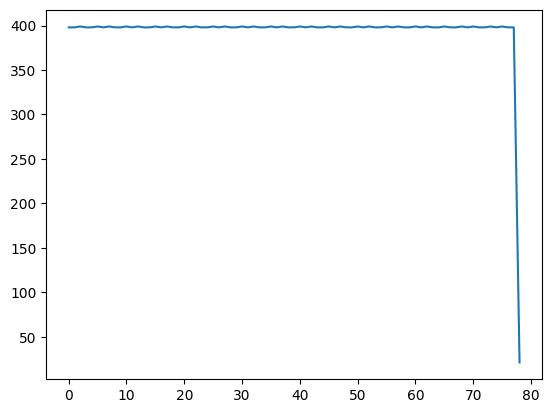

In [26]:
avg,std  = cyc_sec(df['time'])
print(avg,std)

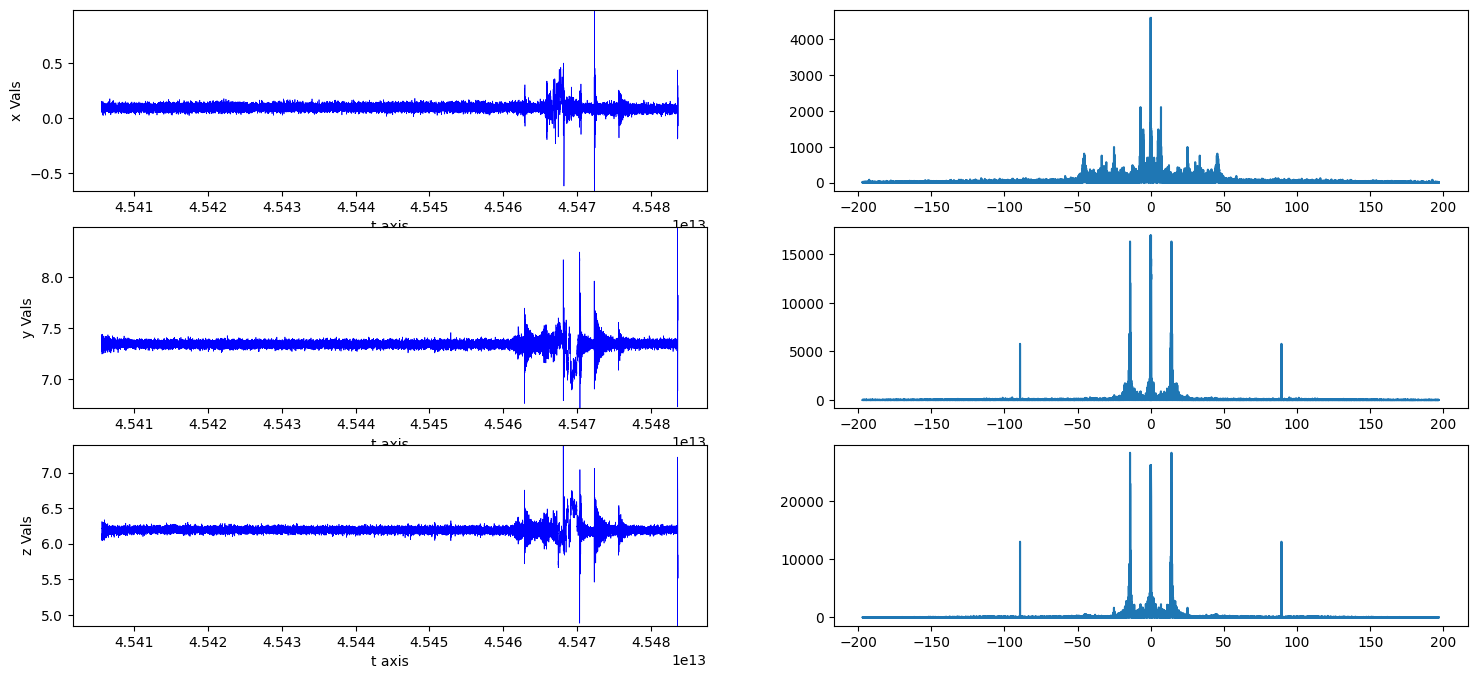

In [27]:
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df[accs[i]].values
    time  = df['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

## treated stationary data

In [28]:
x = list(np.diff(np.diff(df['time'])))
x.insert(0,0)
x.insert(0,0)
df['time_diff'] = x 


In [29]:
df.head()

,time,x,y,z,time_diff
0,45405604266664,0.154587,7.270157,6.135773,0
1,45405606769106,0.113876,7.368317,6.121399,0
2,45405609271547,0.057617,7.419800,6.127396,-1
3,45405611773989,0.067200,7.394653,6.077118,1
4,45405614277065,0.061203,7.393463,6.123795,634


In [30]:
desc = df[df['time_diff']==0].describe().T[['mean','min','50%']].T

In [31]:
desc

,time,x,y,z,time_diff
mean,4.544444e+13,0.098120,7.341583,6.193600,0.0
min,4.540560e+13,-0.477493,6.726669,4.846497,0.0
50%,4.544430e+13,0.097122,7.344376,6.192032,0.0


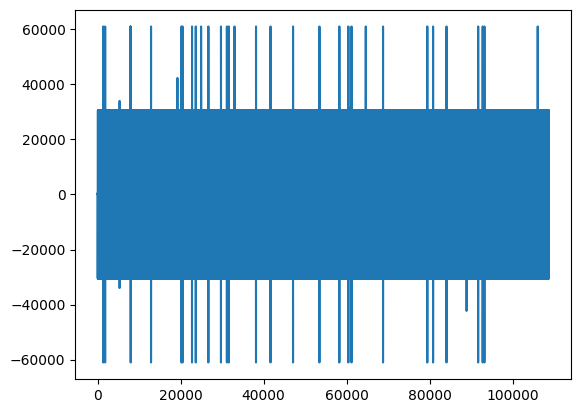

In [35]:
plt.plot(df['time_diff'])

* difference between two time steps on y-axis

### Pretreat df: filling the missing data with smallest deltaT throughout the data

(31600, 5)


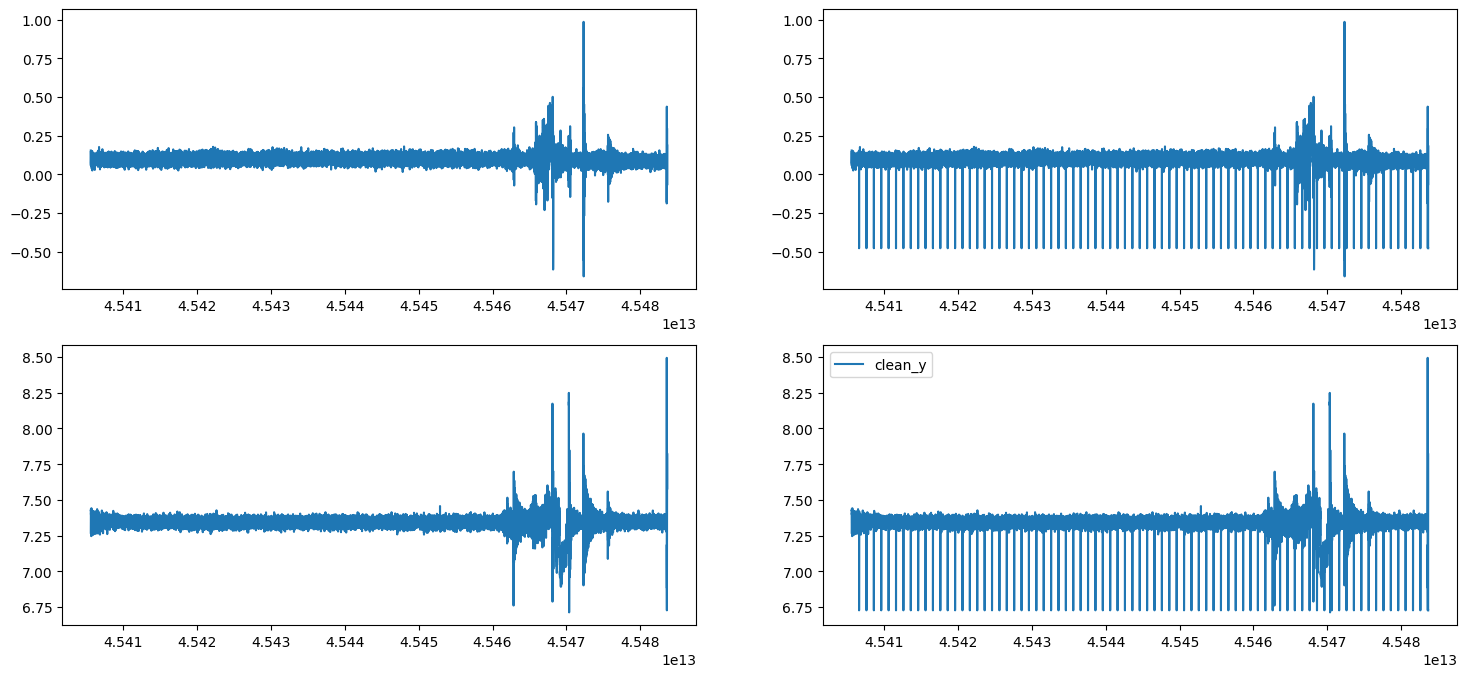

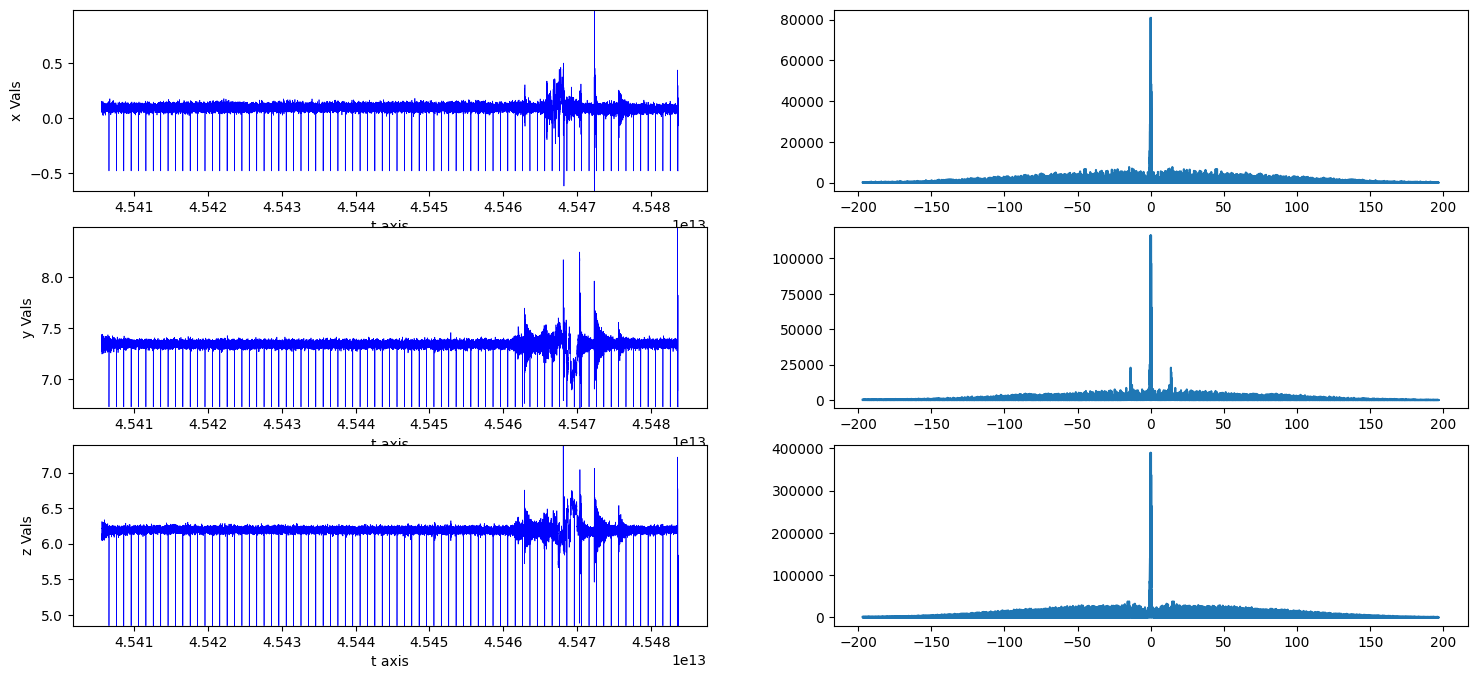

In [36]:
df2 = pd.DataFrame({'time':[],'x':[],'y':[],'z':[]})
dff = df.copy()
n = dff['time'].iloc[0]
x = list(np.diff(np.diff(dff['time'])))
x.insert(0,0)
x.insert(0,0)
dff['time_diff'] = x 
desc = dff[dff['time_diff']==0].describe().T[['mean','min','50%']].T 
while (n < dff['time'].iloc[-1]):
    recs = dff[(dff['time'] >=n) & (dff['time']<n+ 1e+9)].copy()
    # df2.iloc[counter:counter + len(recs)] = recs
    df2 = pd.concat([df2,recs],axis=0)
    if len(recs) < 400:
        t = 400-len(recs)
        # filling the missing data with smallest deltaT within the second
        recs = pd.DataFrame({'time':np.arange(df2['time'].iloc[-1]+1,df2['time'].iloc[-1]+t+1),'x':[desc['x']['min']]*t,'y':[desc['y']['min']]*t,'z':[desc['z']['min']]*t}) # 
        # df2.iloc[counter + len(recs):counter + len(recs) + (400-len(recs))] = 0
        df2 = pd.concat([df2,recs],axis=0)
    n= n+1e+9
print(df2.shape)
# df2.to_csv('cleaned_stationary_df.csv',index=False)
fig, ax = plt.subplots(2,2,figsize=(18,8))
ax[0,0].plot(df.time, df.x, label='unclean_x')
ax[0,1].plot(df2.time,df2.x,label = 'clean_x')
ax[1,0].plot(df.time, df.y, label='unclean_y')
ax[1,1].plot(df2.time,df2.y,label = 'clean_y')
plt.legend()
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df2[accs[i]].values
    time  = df2['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

###  Pretreat df:filling the missing data with smallest deltaT within the second

(31600, 5)


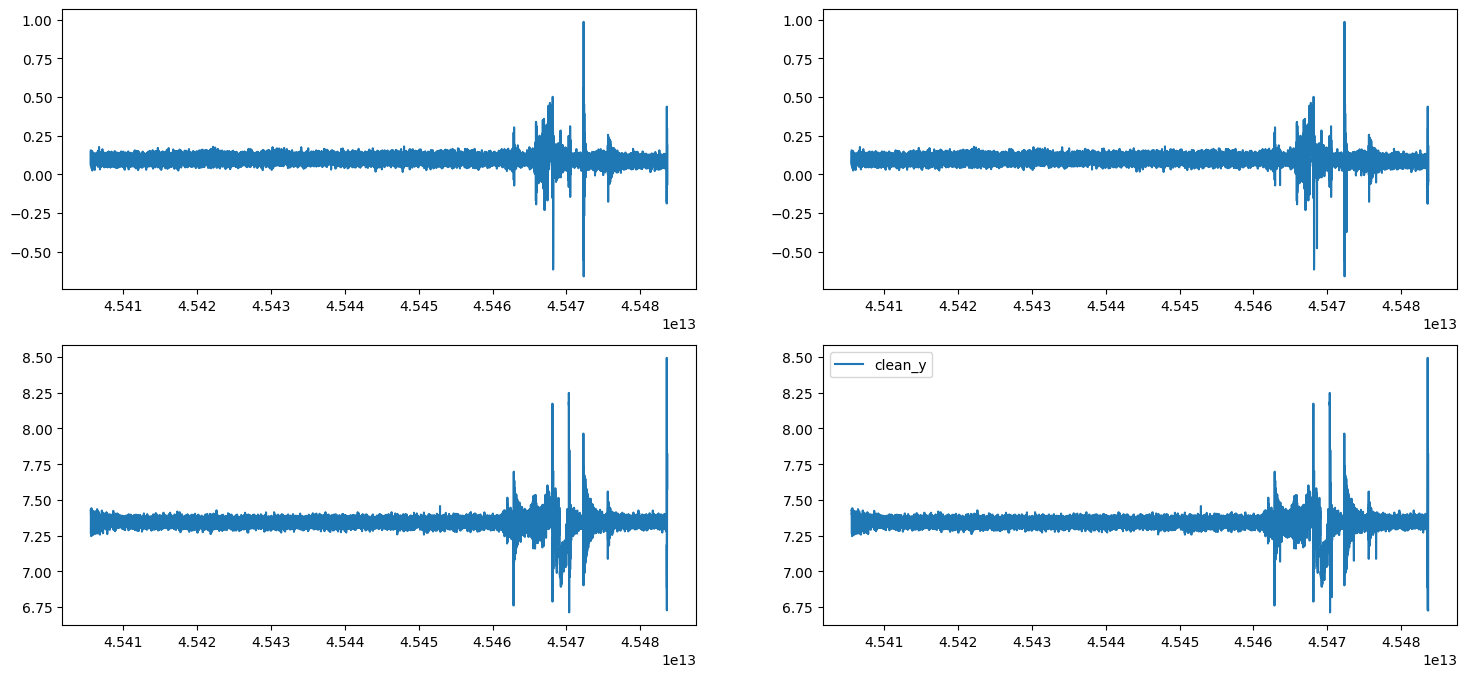

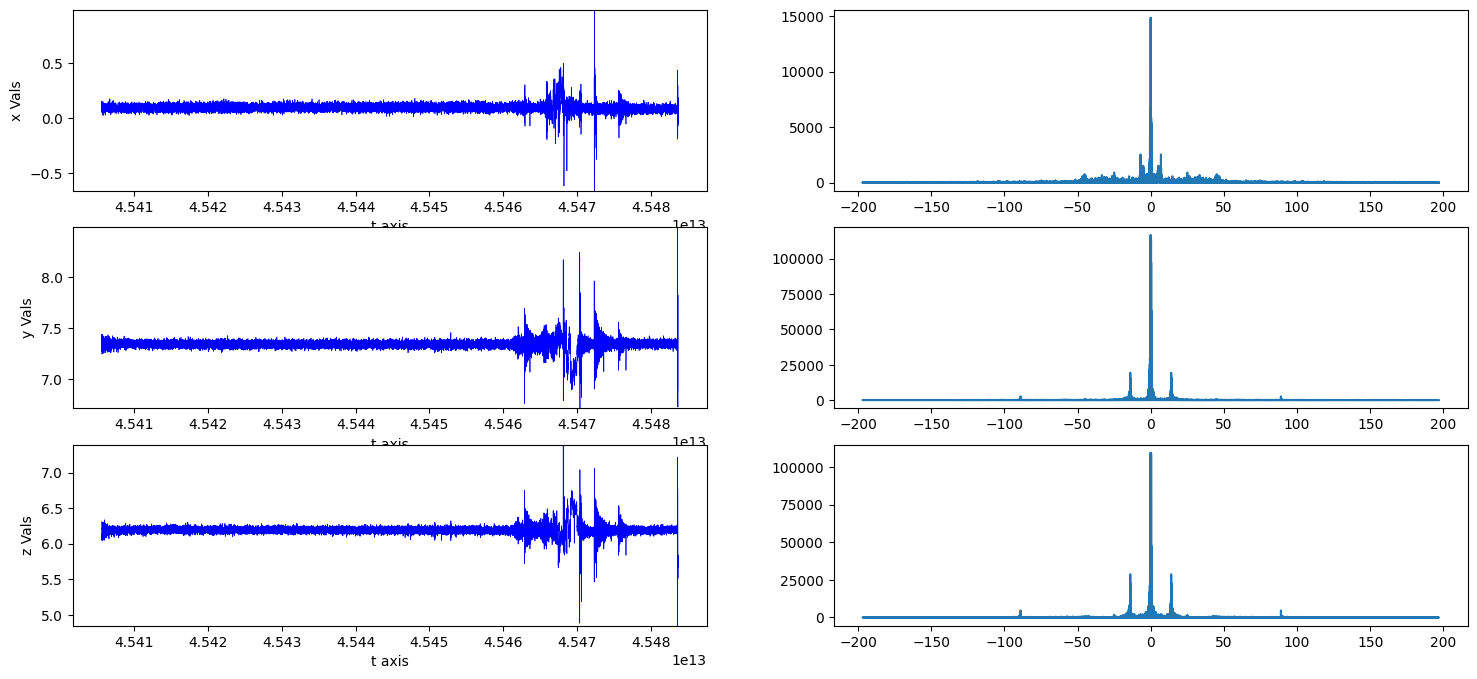

In [37]:

df2 = pd.DataFrame({'time':[],'x':[],'y':[],'z':[]})
n = df['time'].iloc[0]


while (n < df['time'].iloc[-1]):
    recs = df[(df['time'] >=n) & (df['time']<n+ 1e+9)].copy()
    x = list(np.diff(np.diff(recs['time'])))
    x.insert(0,0)
    x.insert(0,0)
    recs['time_diff'] = x 
    desc = recs[recs['time_diff']==0].describe().T[['mean','min','50%']].T 
    # df2.iloc[counter:counter + len(recs)] = recs
    df2 = pd.concat([df2,recs],axis=0)
    if len(recs) < 400:
        t = 400-len(recs)
        # filling the missing data with smallest deltaT within the sec
        recs = pd.DataFrame({'time':np.arange(df2['time'].iloc[-1]+1,df2['time'].iloc[-1]+t+1),'x':[desc['x']['min']]*t,'y':[desc['y']['min']]*t,'z':[desc['z']['min']]*t}) # 
        # df2.iloc[counter + len(recs):counter + len(recs) + (400-len(recs))] = 0
        df2 = pd.concat([df2,recs],axis=0)
    n= n+1e+9
print(df2.shape)
# df2.to_csv('cleaned_stationary_df.csv',index=False)
fig, ax = plt.subplots(2,2,figsize=(18,8))
ax[0,0].plot(df.time, df.x, label='unclean_x')
ax[0,1].plot(df2.time,df2.x,label = 'clean_x')
ax[1,0].plot(df.time, df.y, label='unclean_y')
ax[1,1].plot(df2.time,df2.y,label = 'clean_y')
plt.legend()
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df2[accs[i]].values
    time  = df2['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

* The plots looks much similar now, but new peaks (actually downward peaks) are visible near previous peaks
* peaks has been retained in fft plots

## walking data

In [38]:
df  =pd.read_csv('/Users/atufasheen/Desktop/projects/meiro_work/EP2_Phone in hand_Walking slowly.csv',
                    sep=';',names=['time','type','x','y','z','ang_x','ang_y','ang_z'])
df=df[df['type']==' ACC'][['time','x','y','z']]

385 72


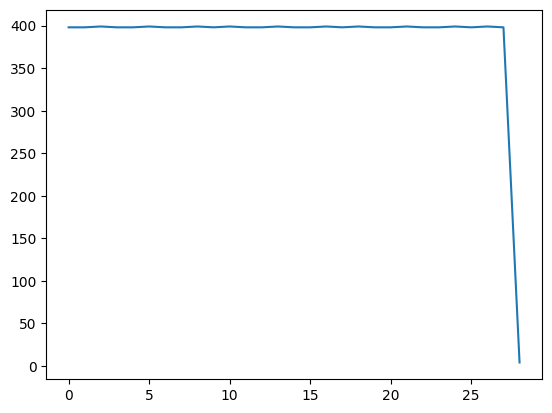

In [39]:
avg,std  = cyc_sec(df['time'])
print(avg,std)

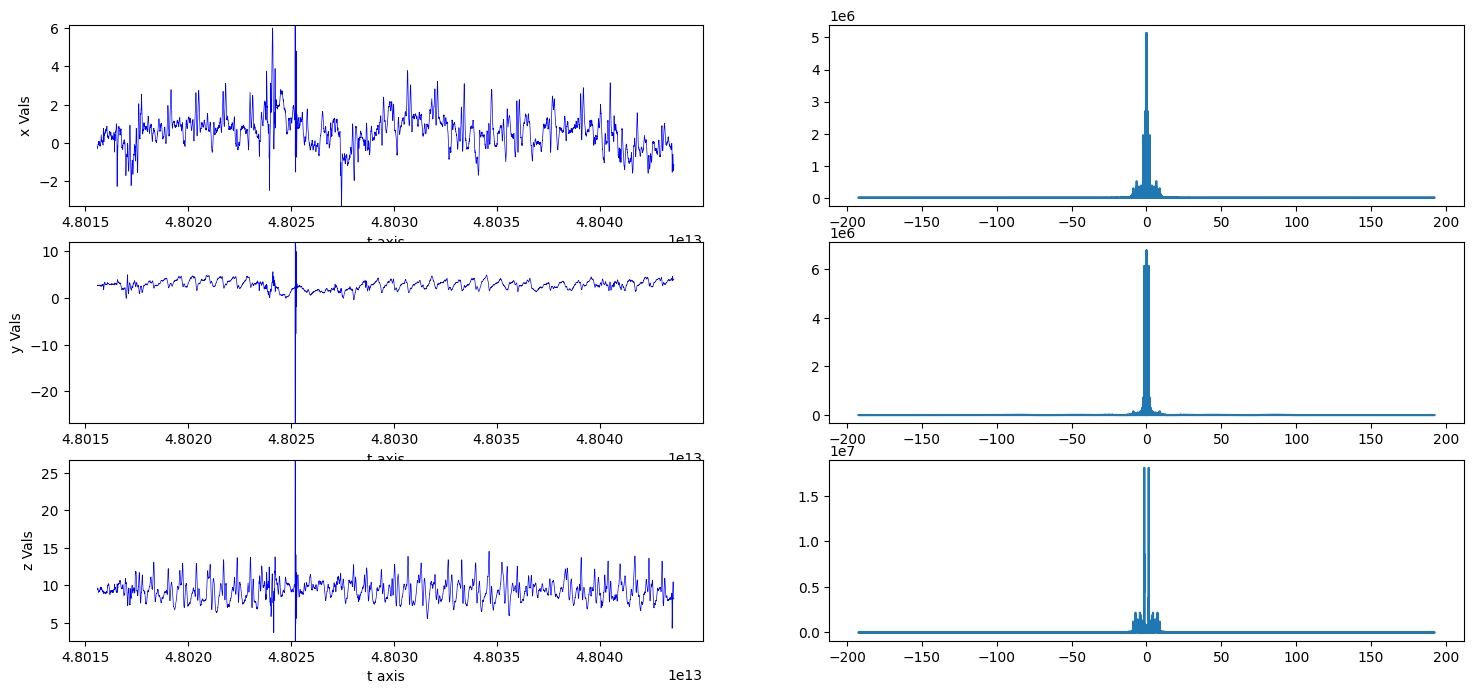

In [116]:
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df[accs[i]].values
    time  = df['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

## treated walking_data

###  Pretreat df: filling the missing data with smallest deltaT within the second

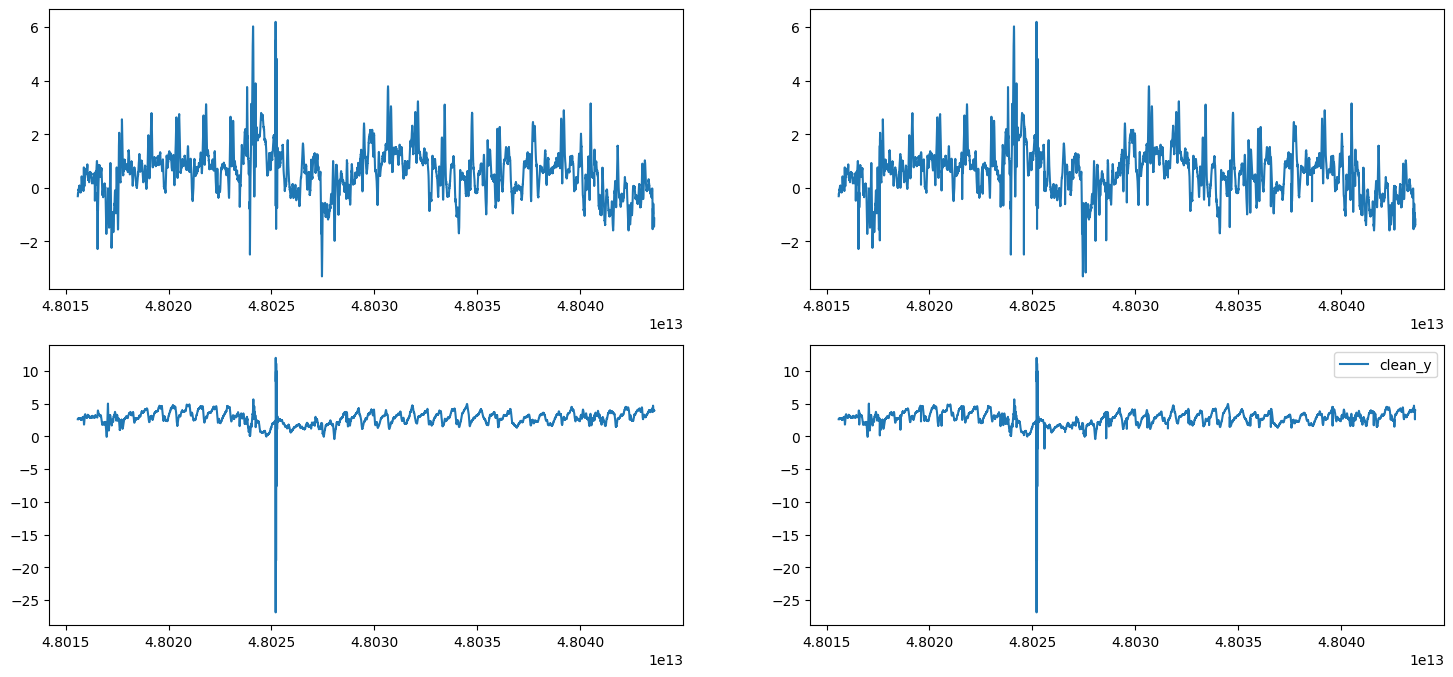

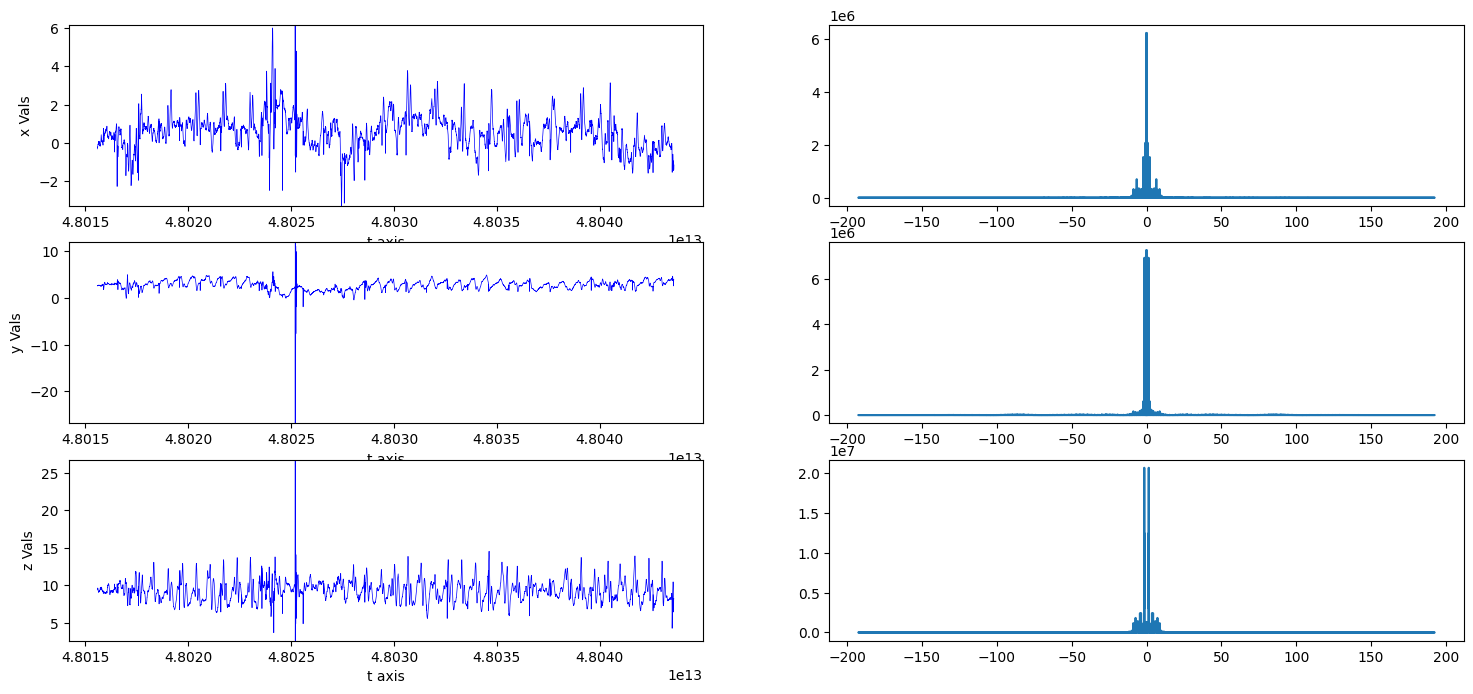

In [40]:

df2 = pd.DataFrame({'time':[],'x':[],'y':[],'z':[]})
n = df['time'].iloc[0]


while (n < df['time'].iloc[-1]):
    recs = df[(df['time'] >=n) & (df['time']<n+ 1e+9)].copy()
    x = list(np.diff(np.diff(recs['time'])))
    x.insert(0,0)
    x.insert(0,0)
    recs['time_diff'] = x 
    desc = recs[recs['time_diff']==0].describe().T[['mean','min','50%']].T
    # df2.iloc[counter:counter + len(recs)] = recs
    df2 = pd.concat([df2,recs],axis=0)
    if len(recs) < 400:
        t = 400-len(recs)
        recs = pd.DataFrame({'time':np.arange(df2['time'].iloc[-1]+1,df2['time'].iloc[-1]+t+1),'x':[desc['x']['min']]*t,'y':[desc['y']['min']]*t,'z':[desc['z']['min']]*t}) # 
        # df2.iloc[counter + len(recs):counter + len(recs) + (400-len(recs))] = 0
        df2 = pd.concat([df2,recs],axis=0)
    n= n+1e+9
# df2.to_csv('cleaned_walking_df.csv',index=False)
fig, ax = plt.subplots(2,2,figsize=(18,8))
ax[0,0].plot(df.time, df.x, label='unclean_x')
ax[0,1].plot(df2.time,df2.x,label = 'clean_x')
ax[1,0].plot(df.time, df.y, label='unclean_y')
ax[1,1].plot(df2.time,df2.y,label = 'clean_y')
plt.legend()
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df2[accs[i]].values
    time  = df2['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

* walking data doesnot have peaks as in stationary data
* walking fft plot seems to have no noise

## finding peaks
try:

z-score one: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data

scipy one: https://stackoverflow.com/questions/35282456/find-local-maximums-in-numpy-array

find_peaks_cwt
Find peaks using the wavelet transformation.

peak_prominences
Directly calculate the prominence of peaks.

peak_widths
Directly calculate the width of peaks.

In [ ]:
def reject_outliers(x,m = 2.):
    m = 2.
    data = amp_freq[0,:]
    d = np.abs(x - np.median(x))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return True if s<m else False


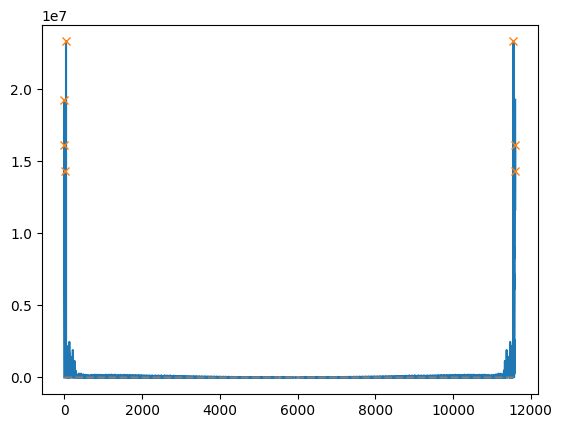

In [128]:
x = amp_freq[0,:]
# x = sample_freq
from scipy.signal import find_peaks
peaks, _ = find_peaks(x, height=np.percentile(x,99.9))
plt.plot(x,)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [37]:
import numpy as np
y = amp_freq[0,:]
slope = [np.sign(y[i]-y[i-1]) for i in range(1, len(y))]

In [38]:
y[19473], y[19472]

(807.0175338908939, 144.55791023403862)

In [39]:
import scipy
g = scipy.signal.argrelextrema(x, np.greater)

In [41]:
len(g[0])

13029